Final negative log likelihood: 296.5983219263583


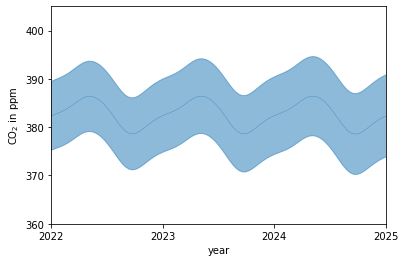

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2
import jax
import jax.numpy as jnp
import jaxopt
from tinygp import kernels, GaussianProcess

from nde import distributions, flows, transforms
import nn as nn_

import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
from torch.nn.utils import clip_grad_norm_

from scipy.stats import norm


# # jax.config.update("jax_enable_x64", True)

# data = co2.load_pandas().data
# t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
# y = np.array(data.co2)
# m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
# t, y = t[m][::4], y[m][::4]



jax.config.update("jax_enable_x64", True)

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]



def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")
gp = build_gp(soln.params, t)


x = np.linspace(1966, 2026, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

plt.xlim(2022, 2025)
plt.ylim(360, 405)
plt.xticks(np.arange(2022, 2026, step=1)) 
plt.yticks(np.arange(360, 410, step=10))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")


In [1]:
from nde import distributions, flows, transforms
import nn as nn_


import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
from torch.nn.utils import clip_grad_norm_

from scipy.stats import norm



num_flow_steps=2
dim=2
hidden_features=64
num_transform_blocks=2
dropout_probability=0.0
use_batch_norm=0
num_bins=128
learning_rate = 5e-4
n_total_steps = 1e3


distribution = distributions.TweakedUniform(
    low=torch.zeros(dim),
    high=torch.ones(dim)
)

distribution = distributions.StandardNormal((2,))

def create_alternating_binary_mask(features, even=True):
    """
    Creates a binary mask of a given dimension which alternates its masking.

    :param features: Dimension of mask.
    :param even: If True, even values are assigned 1s, odd 0s. If False, vice versa.
    :return: Alternating binary mask of type torch.Tensor.
    """
    mask = torch.zeros(features).byte()
    start = 0 if even else 1
    mask[start::2] += 1
    return mask

base_transform_type = 'rq'
def create_base_transform(i, _tail_bound):
    if base_transform_type == 'rq':
        return transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            ),
            num_bins=num_bins,
            apply_unconditional_transform=False,
            tails='linear',
            tail_bound=_tail_bound,
        )
    elif base_transform_type == 'affine':
        return transforms.AffineCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            )
        )
    else:
        raise ValueError
        
        


## =================
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)


import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2
import jax
import jax.numpy as jnp
import jaxopt
from tinygp import kernels, GaussianProcess

# jax.config.update("jax_enable_x64", True)

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]



def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")
gp = build_gp(soln.params, t)



==run on=>  cpu


Final negative log likelihood: 302.68505859375


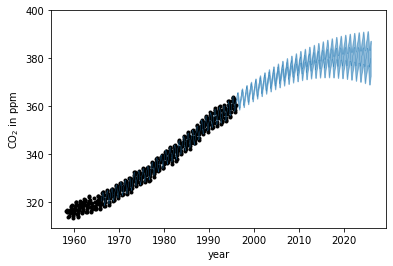

In [3]:
x = np.linspace(1966, 2026, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance


plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

# plt.xlim(1980, 2025)
# plt.ylim(330, 405)
# plt.xticks(np.arange(2022, 2026, step=1)) 
# plt.yticks(np.arange(360, 410, step=10))
# plt.xticks(np.arange(2022, 2026, step=1)) 
plt.yticks(np.arange(320, 401, step=20))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

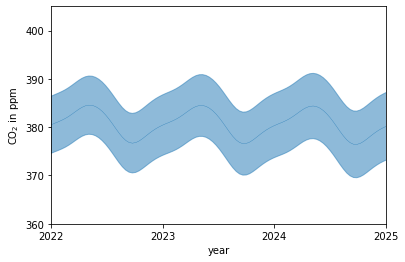

In [2]:
x = np.linspace(1966, 2026, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

plt.xlim(2022, 2025)
plt.ylim(360, 405)
plt.xticks(np.arange(2022, 2026, step=1)) 
plt.yticks(np.arange(360, 410, step=10))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

==run on=>  cpu


Final negative log likelihood: 302.68505859375
100 tensor(-0.0071) 1.8944538831710815
200 tensor(0.0209) 1.874948263168335
300 tensor(-0.0074) 1.859568476676941
400 tensor(-0.0059) 1.8448728322982788
500 tensor(-0.0091) 1.8458247184753418
600 tensor(0.0056) 1.8510866165161133
700 tensor(0.0094) 1.8397585153579712
800 tensor(0.0090) 1.8349422216415405
900 tensor(0.0164) 1.839442491531372
1000 tensor(0.0001) 1.8356879949569702
===> tensor(0.0001) 1.833754539489746


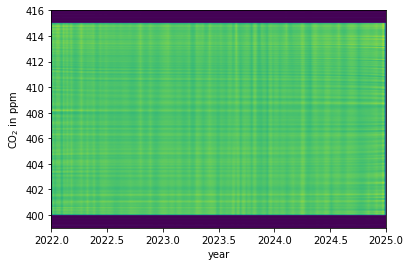

In [1]:
##==========================

def plotDensity(dd=500j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1:1:dd, -1.2:2.2:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        plt.imshow(z.T, origin='lower', extent=[2022,2025,399,416], aspect="auto")
        plt.xlabel("year")
        plt.ylabel("CO$_2$ in ppm")
        plt.show()

def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0] * 1.5 + 2023.5, x[:,1] *5 + 405

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([2022, 2025])
            plt.ylim([400, 410])
            plt.xticks(np.arange(2022, 2026, step=1)) 
            plt.yticks(np.arange(400, 415, step=5)) 
            plt.xlabel("year")
            plt.ylabel("CO$_2$ in ppm")
            plt.show()
        return intgral

def logf(x):
    xx = x[:,0].cpu().numpy()*1.5 + 2023.5
    cond_gp = gp.condition(y, xx).gp  ### <<<<==============
    mu, var = np.asarray(cond_gp.loc), np.asarray(cond_gp.variance)
    return -(torch.log(2*torch.pi*torch.FloatTensor(var)) + (x[:,1]*5 + 405 - mu)**2 / var )/2   \
             + torch.log(x[:,0]>-1) + torch.log(x[:,0]<1) + torch.log(x[:,1]>-1) 
    # return -( torch.log(torch.FloatTensor(var))   )/2   

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n):
    x = np.random.uniform(size=n, low =-1, high=1)
    y = np.random.uniform(size=n, low =-1, high=2)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))


transform = transforms.CompositeTransform(
    [create_base_transform(i, 2.5) for i in range(num_flow_steps)])
flow = flows.Flow(transform, distributions.StandardNormal((2,))).to(device)

optimizer_servy = optim.Adam(flow.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_servy, n_total_steps)

history = []
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(2000).to(device)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    optimizer_servy.zero_grad()
    

    log_prob = flow.log_prob(inputs)
    loss = -torch.mean(log_prob) # calLoss(inputs, log_prob)
    loss.backward()
    optimizer_servy.step()
    scheduler.step()
    # history.append(loss.item())
print("===>", inputs[:,0].mean(), loss.item())
plotDensity()


NameError: name 'x' is not defined

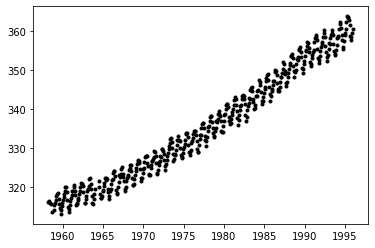

In [4]:
plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

plt.xlim(2022, 2025)
plt.ylim(360, 405)
plt.xticks(np.arange(2022, 2026, step=1)) 
plt.yticks(np.arange(360, 410, step=10))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

In [ ]:
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_refine, n_total_steps)  
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    with torch.no_grad():
        _ = flow.eval()
        inputs = flow.sample(1500).detach()
        # inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    # scheduler.step(epoch)
    optimizer_refine.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotDensity()


In [ ]:
def plotDensity(dd=500j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1:1:dd, -1:1.2:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        plt.imshow(z.T, origin='lower', extent=[2022,2025,400,411], aspect="auto")
        plt.xticks(np.arange(2022, 2026, step=1)) 
        plt.yticks(np.arange(400, 415, step=5))
        plt.xlabel("year")
        plt.ylabel("CO$_2$ in ppm")
        plt.show()

plotDensity()

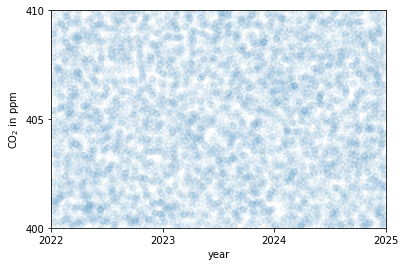

real: 1.0000000000,
mean: 0.0024736361,
 std: 0.0000273519, 
accuracy: 0.247%


In [3]:
v = [calIntegral(i==0, 10000)* 1.5 * 5 /3 for i in range(2)]
real = 1
print("real: %.10f,\nmean: %.10f,\n std: %.10f, \naccuracy: %.3f%%" % (real, np.mean(v),
                                np.std(v), (1-np.abs(np.mean(v) - real)/real)*100))


In [ ]:
def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0] * 1.5 + 2023.5, x[:,1] *5 + 405

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([2022, 2025])
            plt.ylim([400, 410])
            plt.xticks(np.arange(2022, 2026, step=1)) 
            plt.yticks(np.arange(400, 415, step=5)) 
            plt.xlabel("year")
            plt.ylabel("CO$_2$ in ppm")
            plt.show()
        return intgral
    
[calIntegral(i==0, 10000)* 1.5 * 5 /3 for i in range(1)]